# Machine Learning using Multivariate Linear Regression

Estimating the profit from a city basing on its population size.

In [1]:
import pandas as pd
# import pandas_profiling
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import meshgrid, cm
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

sns.set(style="whitegrid")

In [2]:
print('Plotting Data ...\n')
data = pd.read_csv('ex1data2.txt', names = ['size', 'qty_bedrooms', 'price'])
data = data.astype('float64')
print(data.head())

Plotting Data ...

     size  qty_bedrooms     price
0  2104.0           3.0  399900.0
1  1600.0           3.0  329900.0
2  2400.0           3.0  369000.0
3  1416.0           2.0  232000.0
4  3000.0           4.0  539900.0


In [3]:
print('Profiling Data')
data.info()
# pandas_profiling.ProfileReport(data)

Profiling Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47 entries, 0 to 46
Data columns (total 3 columns):
size            47 non-null float64
qty_bedrooms    47 non-null float64
price           47 non-null float64
dtypes: float64(3)
memory usage: 1.2 KB


In [4]:
x = np.array(data[['size', 'qty_bedrooms']]) # training set
y = data['price'] # labels
m = len(y) # training size

In [5]:
"""
Normalizes the features in X 
returns a normalized version of X where the mean value of each feature is 0 and the standard deviation is 1.
This is often a good preprocessing step to do when working with learning algorithms.

First, for each feature dimension, compute the mean of the feature and subtract it from the dataset,
storing the mean value in mu. Next, compute the  standard deviation of each feature and divide
each feature by it's standard deviation, storing the standard deviation in sigma.
"""
def featureNormalize(X):
    X_norm = np.zeros(np.shape(X))
    qty_features = np.shape(X)[1]
    mu = np.zeros(qty_features)
    sigma = np.zeros(qty_features)
    
    for i in range(qty_features):
        mu[i] = np.mean(X[:,i])
        X_norm[:,i] = X[:,i] - mu[i]
        
        # by default np.std calculate the population std, here we want sample std (as done in Octave)
        sigma[i] = np.std(X_norm[:,i], ddof=1) # default: ddof=0 (N - 0) will predict 293092.21273075533
        X_norm[:,i] = X_norm[:,i] / sigma[i]
    return X_norm, mu, sigma

In [6]:
# Tessting Feature Normalization
X_ = np.array([
    [2104, 3],
    [1600, 3],
    [2400, 3],
    [1416, 2],
    [3000, 4]
])
X_n, mu_, sigma_ = featureNormalize(X_)
print("X Norm", X_n)
print("mu", mu_) # [2104.    3.]
print("sigma", sigma_) # [635.96226303   0.70710678]

X Norm [[ 0.          0.        ]
 [-0.79249985  0.        ]
 [ 0.46543642  0.        ]
 [-1.0818252  -1.41421356]
 [ 1.40888863  1.41421356]]
mu [2104.    3.]
sigma [635.96226303   0.70710678]


In [7]:
# Scale features and set them to zero mean
print('Normalizing Features ...\n')

X, mu, sigma = featureNormalize(x)

print('Normalized data')
X[:5]

Normalizing Features ...

Normalized data


array([[ 0.13000987, -0.22367519],
       [-0.50418984, -0.22367519],
       [ 0.50247636, -0.22367519],
       [-0.73572306, -1.53776691],
       [ 1.25747602,  1.09041654]])

Add a column of ones to X to facilitate the manipulation.

Each row is a input with the following format:

$X[0] = [ x_0, x_1, x_2 ]$ where $x_0 = 1$

In [8]:
# Add a column of ones to X to facilitate the manipulation
X = np.column_stack((np.ones(m), X))
X[:5]

array([[ 1.        ,  0.13000987, -0.22367519],
       [ 1.        , -0.50418984, -0.22367519],
       [ 1.        ,  0.50247636, -0.22367519],
       [ 1.        , -0.73572306, -1.53776691],
       [ 1.        ,  1.25747602,  1.09041654]])

## ================ Part 2: Gradient Descent ================

### Hypothesis Function
Function that defines our linear model.

Definition:

$h_\theta(x) = \theta_0 + \theta_1 * x_1 + \theta_2 * x_2$

Vectorial form:

$h_\theta(x) = \theta^{T} * x$

where:
$x = [x_0, x_1, x_2]$; $x_0 = 1$ and $\theta = [\theta_0, \theta_1, \theta_2]$

In [9]:
def hypothesisMulti(X, theta):
    # return [np.dot(xi, theta) for xi in X]
    return X.dot(theta)

### Compute cost for linear regression
`computeCost` computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.

Function cost:

$ J(\theta) = \frac{1}{2m} \sum_{i=0}^{m} (h_\theta(x^{(i)}) - y^{(i)})^{2} $

In [10]:
"""
Inputs:
X = [
  [ x0, x1, x2 ]
]
y = [
  [ ]
]
theta = [ theta_0, theta_1, theta_2 ]
"""
def computeCostMulti(X, y, theta):
    m = len(y)
    h_theta = hypothesisMulti(X, theta)
    # j = (1 / (2 * m)) * ((h_theta - y) ** 2).sum()
    j = (1 / (2 * m)) * (h_theta - y).T.dot(h_theta - y)
    return j

### Running Gradient Descent
We use gradient descent to find the parameters values $\theta$ that **minimize** $J$.
In each iteration we calculate a $\theta'$ where $J(\theta') < J(\theta)$.

This $\theta'$ defined by $\theta' = \theta - \alpha * \nabla h_\theta$, where $\nabla h_\theta$ is the amount we need change to *minimize* $J(\theta)$ and $\alpha$ is the step we will take.

If $\alpha$ is too large we could ending increasing $J$, it need to be small enough to converge quickly to the points the $J(\theta)$ is minimum.


Step to update each parameter:

$\theta_j := \theta_j - \alpha * \frac{\partial J}{\partial \theta_j} $

Where:

$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} [( h_\theta(x^{(i)}) - y^{(i)})$ when $j = 0$ (bacause it is the bias - doesn't have a feature).

$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} [( h_\theta(x^{(i)}) - y^{(i)}) * x^{(i)}]$ when $j > 1$.


Metrix form:

$ \frac{\partial J}{\partial \theta_j} = \frac{1}{m} = X^{T} ( h_\theta(x^{(i)}) - y^{(i)}) $


`gradientDescent(X, y, theta, alpha, num_iters)` performs gradient descent to learn $\theta$ parameters.

It return the an array with $\theta$ containing the values found by taking num_iters gradient steps with learning rate alpha.

Also it return a array with the history of $J(\theta)$ to be plotted.

In [11]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):
    m = len(y)
    J_history = np.zeros(num_iters)
    
    for i in range(num_iters):
        h_theta = hypothesisMulti(X, theta)
        nabla = (1 / m) * (h_theta - y).T.dot(X);

        theta = theta - alpha * nabla.T
        
        # Save the cost J in every iteration
        J_history[i] = computeCostMulti(X, y, theta);
    return theta, J_history

In [12]:
# Testing gradientDescentMulti
theta, J_history = gradientDescentMulti(X, y, np.zeros(3), 0.3, 50)
print(theta)
# [340412.65345227 110572.96193087  -6591.38592285]

[340412.65345227 110572.96193087  -6591.38592285]


After that, try running gradient descent with different values of alpha and see which one gives you the best result.

In [13]:
# computeCostMulti(np.array([X[0]]), np.array([y[0]]), np.zeros(3)) # should print 79960005000.0
num_iters = 50; # with alpha = 0.01 we should rise the # of iterations
alphas = [0.01, 1, 0.1, 0.3]
colors = ['b', 'r', 'y', 'g'];

Running gradient descent ...



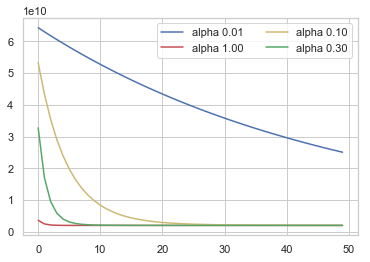

In [14]:
# To plot the J(theta) using different alphas
fig, ax = plt.subplots()
iterations = range(num_iters)

print('Running gradient descent ...\n')
for alpha, color in zip(alphas, colors):
    theta = np.zeros(3) # reset the theta to the current alpha
    
    theta, J_history = gradientDescentMulti(X, y, theta, alpha, num_iters)
    # print('alpha ', alpha, ' found theta ', theta)
    plt.plot(iterations, J_history, color=color, label='alpha %.2f' % alpha)
    
plt.legend(loc='best', ncol=2)

In [15]:
# Display gradient descent's result
print('Theta computed from gradient descent:');
print(theta);

Theta computed from gradient descent:
[340412.65345227 110572.96193087  -6591.38592285]


In [16]:
# Estimate the price of a 1650 sq-ft, 3 br house
predict = [1650, 3]
# normalize and add the x_0 = 1
predict_norm = np.column_stack((np.ones(1), [((predict - mu) / sigma)]))

In [17]:
price = hypothesisMulti(predict_norm, theta)[0] # 293094.09812
print("Predicted price: ", price)

Predicted price:  293094.0981218172


### ================ Part 3: Normal Equations ================

In [18]:
# Load again as we don't need to apply feature normalization
x = np.array(data[['size', 'qty_bedrooms']]) # training set
y = data['price'] # labels
m = len(y) # training size

X = np.column_stack((np.ones(m), x))

Computes the closed-form solution to linear regression using the normal equations.

$ inv(X^{T} * X) * X^{T} * y $

In [19]:
def normalEqn(X, y):
    xxInv = np.linalg.inv(np.matmul(X.transpose(), X))
    return np.matmul(np.matmul(xxInv, X.transpose()), y)

In [20]:
print('Solving with normal equations...')
theta = normalEqn(X, y)
print(theta)

Solving with normal equations...
[89597.9095428    139.21067402 -8738.01911233]


In [21]:
# Estimate the price of a 1650 sq-ft, 3 br house
predict = np.column_stack((np.ones(1), [[1650, 3]]))
price = hypothesisMulti(predict, theta)[0] # 293081.46
print("Predicted price: ", price)

Predicted price:  293081.4643348959
